In [153]:
import stellargraph as sg
import networkx as nx
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np

from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from stellargraph.data import BiasedRandomWalk
from gensim.models import Word2Vec

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML

from neo4j import GraphDatabase
from node2vec import Node2Vec
from stellargraph import StellarGraph

%matplotlib inline

## Connect to the Database

In [154]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = "OLIV00%%"

driver = GraphDatabase.driver(uri, auth=(username, password))

In [155]:
graph = nx.Graph()

with driver.session() as session:
    # Récupérer les nœuds avec toutes leurs propriétés
    nodes_query = "MATCH (n) RETURN n"
    nodes_result = session.run(nodes_query)

    # Parcourir les résultats et ajouter les nœuds au graphe avec toutes leurs propriétés
    for record in nodes_result:
        node_properties = dict(record["n"].items())  # Access node properties as a dictionary
        node_id = record["n"].element_id
        graph.add_node(node_id, **node_properties)

    # Récupérer les relations avec toutes leurs propriétés
    relations_query = "MATCH ()-[r]->() RETURN r"
    relations_result = session.run(relations_query)

    # Ajouter les relations entre les nœuds avec toutes leurs propriétés
    for record in relations_result:
        rel_properties = dict(record["r"].items())  # Access relationship properties as a dictionary
        src_node_id = record["r"].start_node.element_id
        dst_node_id = record["r"].end_node.element_id
        graph.add_edge(src_node_id, dst_node_id, **rel_properties)

In [157]:
graph = nx.Graph()

with driver.session() as session:
    # Récupérer les nœuds avec leur nom et type
    nodes_query = "MATCH (n) RETURN ID(n) AS id, n.name AS name, n.type AS type"
    nodes_result = session.run(nodes_query)

    # Parcourir les résultats et ajouter les nœuds au graphe
    for record in nodes_result:
        node_id = record["id"]
        node_name = record["name"]
        node_type = record["type"]
        if node_id is not None:
            graph.add_node(node_id, name=node_name, type=node_type)

    # Récupérer les relations
    relations_query = "MATCH ()-[r]->() RETURN ID(startNode(r)) AS source_id, ID(endNode(r)) AS target_id"
    relations_result = session.run(relations_query)

    # Ajouter les relations entre les nœuds
    for record in relations_result:
        source_node_id = record["source_id"]
        target_node_id = record["target_id"]
        if source_node_id is not None and target_node_id is not None:
            graph.add_edge(source_node_id, target_node_id)

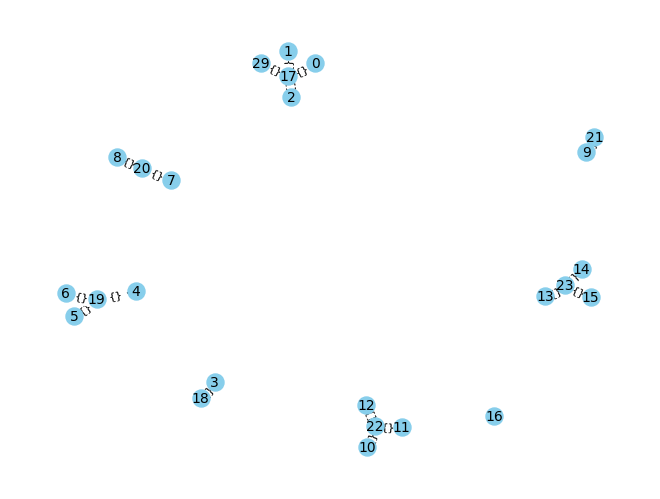

In [162]:
# Create a layout for visualization (e.g., circular layout)
pos = nx.spring_layout(graph)

# Draw nodes with labels and node properties
node_labels = {node_id: f"{node_id}\n{node_data}" for node_id, node_data in graph.nodes(data=True)}
nx.draw(graph, pos, with_labels=True, node_size=150, node_color="skyblue", font_size=10)

# Draw edges with edge properties
edge_labels = {(u, v): data for u, v, data in graph.edges(data=True)}
nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8)

# Display the graph
plt.show()

In [142]:
# Convert the NetworkX graph to a StellarGraph object
G = sg.StellarGraph.from_networkx(graph)

# Define the target link prediction task as edge prediction (binary classification)
edges = list(graph.edges())
targets = np.ones(len(edges))

edges_train, edges_test, targets_train, targets_test = train_test_split(edges, targets, train_size=0.8, random_state=42)

# Create the GraphSAGE link generator
batch_size = 20
num_samples = [10, 5]  # The number of nodes sampled in each layer of GraphSAGE
train_gen = GraphSAGELinkGenerator(G, batch_size, num_samples)

# Generate the training data using the link generator
train_flow = train_gen.flow(edge_ids=edges_train, targets=targets_train, shuffle=True)

# Create the GraphSAGE model
layer_sizes = [32, 32]  # The size of the GraphSAGE layers
graphsage = GraphSAGE(layer_sizes=layer_sizes, generator=train_gen)

# Build the model for link prediction task
x_inp, prediction = link_classification(
    graphsage,
    edge_embedding_method="concat",
    edge_embedding_method_kwargs={"method": "hadamard"},  # Use Hadamard method for link prediction
    projected_feature_dim=32,
    dropout=0.5,
)

# Compile the model
model = Model(inputs=x_inp, outputs=prediction)
model.compile(optimizer=Adam(learning_rate=0.005), loss="binary_crossentropy", metrics=["acc"])

# Train the model
epochs = 50
model.fit(train_flow, epochs=epochs)

# Generate the testing data using the link generator
test_gen = train_gen.flow(edge_ids=edges_test, targets=targets_test)
test_metrics = model.evaluate(test_gen)

print(f"Test loss: {test_metrics[0]}, Test accuracy: {test_metrics[1]}")


RuntimeError: This StellarGraph has no numeric feature attributes for nodesNode features are required for machine learning